In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import sys
import numpy as np
import torch 
import lightning
import matplotlib.pyplot as plt
from networks import *
from torchsummary import summary
from utils import *
import random
import tqdm
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from torch.utils.data import DataLoader
import pandas as pd
%load_ext autoreload
%autoreload 2

In [2]:
#initialize datasets
batchsize=16
path_sparse = '/data-pool/data_no_backup/ga63cun/PE/64/'
path_gt = '/data-pool/data_no_backup/ga63cun/PE/4095/'
save_path = "./model_weights/2DUNet/"

df_train = pd.read_csv("./Test_allImages.csv") #I just put in the test csv path here
df_val = pd.read_csv("./Test_allImages.csv") #I just put in the test csv path here

#initialize training parameters
lr = 5e-5
weight_decay = 1e-2
optimizer_algo = "AdamW"
optimizer_params={"weight_decay": weight_decay}
scheduler_algo = "StepLR"
scheduler_params = {"step_size":4, "gamma":0.9}
patch_size = (256, 256)
ww = 3_000
wl = 0

In [3]:
dataset_train = SparseDataset(df = df_train, 
                 path_sparse = path_sparse, 
                 path_gt = path_gt, 
                 augmentation = True, 
                 image_size=patch_size, 
                 ww=ww, 
                 wl=wl
                             )

dataset_val = SparseDataset(df = df_val, 
                 path_sparse = path_sparse, 
                 path_gt = path_gt, 
                 augmentation = False, 
                 image_size=patch_size, 
                 ww=ww, 
                 wl=wls
                           )

dataloader_train = DataLoader(dataset_train, batch_size=batchsize, num_workers=4, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batchsize, num_workers=4, shuffle=False)

In [4]:
#test dataloader

batch_sparse_train, batch_gt_train, batch_label_train = next(iter(dataloader_train))
batch_sparse_val, batch_gt_val, batch_label_val = next(iter(dataloader_val))

tensor([1, 1, 0, 1])
tensor([0, 0, 0, 0])


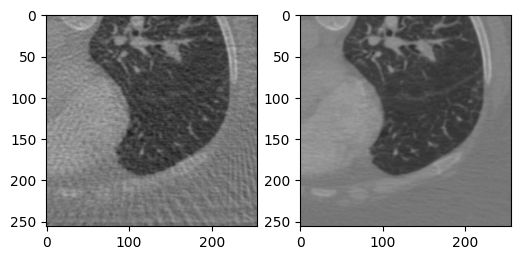

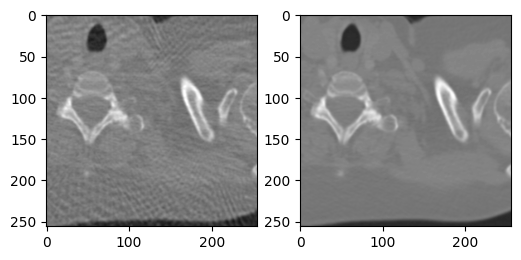

In [5]:
k=0

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
print(batch_label_train[k])
ax[0].imshow(batch_sparse_train[k, 0], cmap='gray', vmin=0, vmax=1)
ax[1].imshow(batch_gt_train[k, 0], cmap='gray', vmin=0, vmax=1)

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
print(batch_label_val[k])
ax[0].imshow(batch_sparse_val[k, 0], cmap='gray', vmin=0, vmax=1)
ax[1].imshow(batch_gt_val[k, 0], cmap='gray', vmin=0, vmax=1)


In [6]:
#initialize model
unet = UNet(n_channels=1, n_classes=1, bilinear=True).float()

In [7]:
model = LitModel(unet=unet, 
                 optimizer_algo=optimizer_algo, 
                 optimizer_params=optimizer_params,
                 loss = nn.MSELoss(reduction='mean'), 
                 lr = lr,
                 scheduler_algo="StepLR",
                 scheduler_params=scheduler_params
                   )

lr_monitor = L.pytorch.callbacks.LearningRateMonitor(logging_interval='epoch')
tblogger = TensorBoardLogger(save_path)
csvlogger = CSVLogger(save_path, version=tblogger.version)
checkpoint = ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=3)
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=7)

trainer = L.Trainer(logger=[csvlogger, tblogger], 
                    callbacks=[lr_monitor, checkpoint, early_stopping], 
                    max_epochs=400)

Missing logger folder: ./model_weights/2DUNet/lightning_logs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/usr/local/lib/python3.8/dist-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2024-09-12 07:20:56.365242: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-12 07:20:57.099611: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
LOCAL_RANK: 0 - CUDA_VISIBLE_D

Finding best initial lr:   0%|          | 0/150 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=150` reached.
Learning rate set to 6.730674999305024e-05
Restoring states from the checkpoint path at /users/Thalhammer/3DCNN_ArtifactReduction/.lr_find_768d76ad-00df-4857-8308-081e04ae221f.ckpt
Restored all states from the checkpoint at /users/Thalhammer/3DCNN_ArtifactReduction/.lr_find_768d76ad-00df-4857-8308-081e04ae221f.ckpt


6.730674999305024e-05


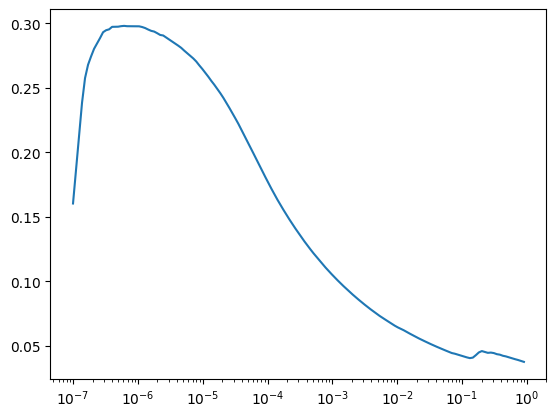

In [8]:
# find learning rate
from lightning.pytorch.tuner import Tuner
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(model, dataloader_train, min_lr=1e-7, max_lr=9e-1, num_training=150, early_stop_threshold=50)
print(lr_finder.suggestion())
plt.plot(lr_finder.results["lr"], lr_finder.results["loss"])
plt.xscale("log")

In [10]:
#test if model overfits on 2 batches
trainer = L.Trainer(logger=[csvlogger, tblogger], 
                    callbacks=[lr_monitor, checkpoint, early_stopping], 
                    max_epochs=400, overfit_batches=2)

trainer.fit(model, dataloader_train, dataloader_val)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory ./model_weights/2DUNet/lightning_logs/version_0/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | unet | UNet    | 17.3 M
1 | loss | MSELoss | 0     
---------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.047    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [7]:
#load model from checkpoint
unet = UNet(n_channels=1, n_classes=1, bilinear=True).float()
model = LitModel.load_from_checkpoint("./model_weights/2DUNet/lightning_logs/version_1/checkpoints/epoch=0-step=5.ckpt", unet=unet)